In [1]:
%matplotlib inline

from IPython.display import display as d
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(rc={'figure.figsize':(12,12)})
import glob
import json
import os
import sys
import json
import os
import sys
import multiprocessing
pool = multiprocessing.Pool(multiprocessing.cpu_count())

    
def plot(ax, figurename):
    os.makedirs("figures", exist_ok=True)
    ax.get_figure().savefig(f"figures/{figurename}.pdf" , bbox_inches="tight")
    ax.get_figure().savefig(f"figures/{figurename}.png", bbox_inches="tight")



read and check the ratings file

In [2]:
df = pd.read_csv("ratings.csv")
df["video_name"] = df["video_name"].apply(
    lambda x: os.path.splitext(x.replace("['", "").replace("']", "").split("\\\\")[-1])[0]
)
d(df.head())

,rating,rating_type,timestamp,user_ID,video_ID,video_name
0,3,radio,2019-10-14 09:17:30 263829,1,0,BennuProRes4444.mov_1frame_crf_21_height_0320
1,4,radio,2019-10-14 09:17:40 502017,1,1,weapon8k-standard-60fps-12to1redcode_16x9_444....
2,2,radio,2019-10-14 09:17:53 471399,1,2,classroom.mkv_1frame_crf_18_height_0208
3,3,radio,2019-10-14 09:17:58 815831,1,3,NTIA_4K_Vignette_1_Violin-422p-8bit-60fps-4096...
4,4,radio,2019-10-14 09:18:04 565989,1,4,gooseberry.mkv_1frame_crf_08_height_0544


calculate mean opinion scores, ci values and check outlier (important, video_name := stimuli)

In [3]:
mos_per_videoname = df.groupby(by="video_name").mean().reset_index()[["video_name", "rating"]]
mos_per_videoname = mos_per_videoname.rename(columns={"rating": "mos"})
d(mos_per_videoname.head())

d_wo = pd.DataFrame()
no_out = 0
no_sub = 0
# simple outlier "detection", better use the ITU-Rec XYZ
for userid, group in df.groupby(by="user_ID"):
    no_sub += 1
    comp = pd.merge(group, mos_per_videoname, left_on="video_name", right_on="video_name")
    # calc correlation
    correlation_user_to_mos = comp[["rating", "mos"]].corr(method="pearson")["mos"][0]
    if correlation_user_to_mos < 0.8:
        print(f"outlier user {userid}")
        no_out += 1
    else:
        d_wo = d_wo.append(group, ignore_index=True)

print(f"out of {no_sub} : {no_out} outlier detected")
    
df = d_wo
# calculate final mos values
mos_per_videoname = df.groupby(by="video_name").mean().reset_index()[["video_name", "rating"]]
mos_per_videoname = mos_per_videoname.rename(columns={"rating": "mos"})
d(mos_per_videoname.head())

# calculate ci values
import scipy.stats as st

def confidence(x):
    x = x["rating"]
    y = st.t.interval(0.95, len(x) - 1, loc=np.mean(x), scale=st.sem(x))
    return  y[1] - y[0]


ci = d_wo[["video_name", "rating"]].groupby(by="video_name").apply(confidence).reset_index()
ci = ci.rename(columns={0: "ci"})

d(ci.head())


def std(x):
    x = x["rating"]
    return  x.std()


std = d_wo[["video_name", "rating"]].groupby(by="video_name").apply(std).reset_index()
std = std.rename(columns={0: "std"})
d(std.head())



mos_ci_per_videoname = pd.merge(
    mos_per_videoname, pd.merge(ci, std), 
    left_on="video_name", 
    right_on="video_name"
)
mos_ci_per_videoname = mos_ci_per_videoname.rename(columns={"video_name": "image_name"})
d(mos_ci_per_videoname.head())
mos_ci_per_videoname.to_csv("mos_ci.csv", index=False)
print(len(std), len(mos_ci_per_videoname))

/tmp/ipykernel_308336/1000118900.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mos_per_videoname = df.groupby(by="video_name").mean().reset_index()[["video_name", "rating"]]


,video_name,mos
0,BennuProRes4444.mov_1frame_crf_03_height_0864,3.095238
1,BennuProRes4444.mov_1frame_crf_06_height_0592,2.904762
2,BennuProRes4444.mov_1frame_crf_08_height_0448,2.809524
3,BennuProRes4444.mov_1frame_crf_13_height_0304,2.476190
4,BennuProRes4444.mov_1frame_crf_21_height_0320,2.142857


/tmp/ipykernel_308336/1000118900.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d_wo = d_wo.append(group, ignore_index=True)
/tmp/ipykernel_308336/1000118900.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d_wo = d_wo.append(group, ignore_index=True)
/tmp/ipykernel_308336/1000118900.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d_wo = d_wo.append(group, ignore_index=True)
/tmp/ipykernel_308336/1000118900.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d_wo = d_wo.append(group, ignore_index=True)
/tmp/ipykernel_308336/1000118900.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pa

out of 21 : 0 outlier detected


/tmp/ipykernel_308336/1000118900.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mos_per_videoname = df.groupby(by="video_name").mean().reset_index()[["video_name", "rating"]]


,video_name,mos
0,BennuProRes4444.mov_1frame_crf_03_height_0864,3.095238
1,BennuProRes4444.mov_1frame_crf_06_height_0592,2.904762
2,BennuProRes4444.mov_1frame_crf_08_height_0448,2.809524
3,BennuProRes4444.mov_1frame_crf_13_height_0304,2.476190
4,BennuProRes4444.mov_1frame_crf_21_height_0320,2.142857


/home/stg7/.local/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2343: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/stg7/.local/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2344: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


,video_name,ci
0,BennuProRes4444.mov_1frame_crf_03_height_0864,0.699565
1,BennuProRes4444.mov_1frame_crf_06_height_0592,0.568885
2,BennuProRes4444.mov_1frame_crf_08_height_0448,0.547677
3,BennuProRes4444.mov_1frame_crf_13_height_0304,0.547677
4,BennuProRes4444.mov_1frame_crf_21_height_0320,0.435249


,video_name,std
0,BennuProRes4444.mov_1frame_crf_03_height_0864,0.768424
1,BennuProRes4444.mov_1frame_crf_06_height_0592,0.624881
2,BennuProRes4444.mov_1frame_crf_08_height_0448,0.601585
3,BennuProRes4444.mov_1frame_crf_13_height_0304,0.601585
4,BennuProRes4444.mov_1frame_crf_21_height_0320,0.478091


,image_name,mos,ci,std
0,BennuProRes4444.mov_1frame_crf_03_height_0864,3.095238,0.699565,0.768424
1,BennuProRes4444.mov_1frame_crf_06_height_0592,2.904762,0.568885,0.624881
2,BennuProRes4444.mov_1frame_crf_08_height_0448,2.809524,0.547677,0.601585
3,BennuProRes4444.mov_1frame_crf_13_height_0304,2.476190,0.547677,0.601585
4,BennuProRes4444.mov_1frame_crf_21_height_0320,2.142857,0.435249,0.478091


371 371


perform SOS analysis (cf. [Hoßfeld et al: SOS: the mos is not enought](http://www.comnet.informatik.uni-wuerzburg.de/team/mitarbeiter/hossfeld/?tx_extbibsonomycsl_publicationlist%5BuserName%5D=uniwue_info3&tx_extbibsonomycsl_publicationlist%5BintraHash%5D=8151bc466638649fbec7ba55d8c97124&tx_extbibsonomycsl_publicationlist%5BfileName%5D=conf_422.pdf&tx_extbibsonomycsl_publicationlist%5Bcontroller%5D=Document&cHash=b602784dc7befe57424e55d7c5602199))

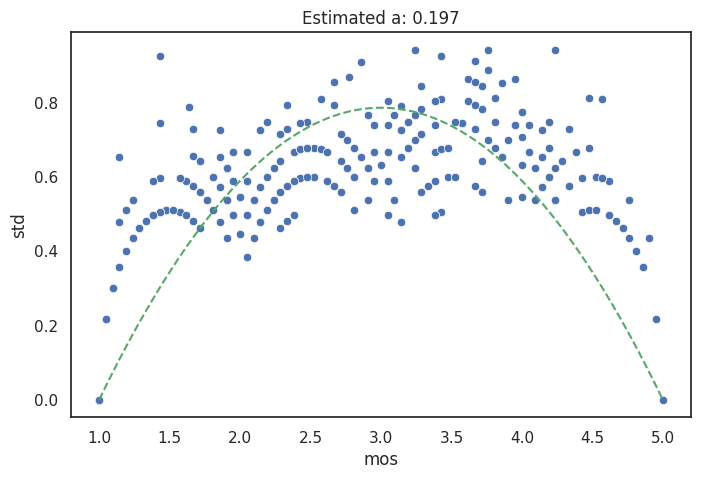

In [4]:
import seaborn as sns

sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("white")
# draw a SOS plot
# read: http://materials.dagstuhl.de/files/15/15022/15022.TobiasHo%C3%9Ffeld1.Preprint.pdf
# for a more detailed description of SOS plots

ax = sns.scatterplot(x="mos", y="std", data=mos_ci_per_videoname)

#, with the y=(x-1)*(x-5)* a interpolated function 

x_data = mos_ci_per_videoname["mos"].values
y_data = mos_ci_per_videoname["std"].replace(np.NaN, 0).values

from scipy.optimize import curve_fit

def fitting_function(x, a):
    return (x - 1) * (x - 5) * (-a)

popt, pcov = curve_fit(fitting_function, x_data, y_data) 


x = np.linspace(1, 5, 100)
ax.plot(x, fitting_function(x, *popt), 'g--')
ax.set_title(f"Estimated a: {popt[0].round(3)}")

plot(ax, "sos")

parameter $a$ seems to be typical and ok for a image quality test, e.g. reported for IRCCyN/IVC Scores on
Toyama is around 0.17

next is to create the per user rating table

In [5]:
# create per user file
per_user = [] 
for i, g in df.groupby(by="video_name"):
    v = {
        "image_name": i,
        "mos": g["rating"].mean(),
        "ci": confidence(g)
    }
    for j, gg in g.groupby(by="user_ID"):
        user = "user" + str(j)
        v[user] = gg["rating"].values[0]
    per_user.append(v)

du = pd.DataFrame(per_user)
ucols = ["image_name"] + [x for x in du.columns if "user" in x] + ["mos", "ci"]
d(du[ucols].head())
du[ucols].to_csv("per_user.csv", index=False)

/home/stg7/.local/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2343: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/stg7/.local/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2344: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/home/stg7/.local/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2343: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/stg7/.local/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2344: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/home/stg7/.local/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2343: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/stg7/.local/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2344: RuntimeWarning: invalid v

,image_name,user1,user2,user3,user4,user5,user6,user7,user8,user9,...,user14,user15,user16,user17,user18,user19,user20,user21,mos,ci
0,BennuProRes4444.mov_1frame_crf_03_height_0864,4,3,3,3,5,3,4,3,3,...,2,3,3,2,4,3,3,3,3.095238,0.699565
1,BennuProRes4444.mov_1frame_crf_06_height_0592,4,3,3,3,4,2,3,3,3,...,2,3,3,2,3,3,4,2,2.904762,0.568885
2,BennuProRes4444.mov_1frame_crf_08_height_0448,4,2,3,2,4,2,3,3,3,...,3,3,3,2,3,3,3,3,2.809524,0.547677
3,BennuProRes4444.mov_1frame_crf_13_height_0304,3,2,3,2,3,2,2,2,3,...,2,3,3,3,3,3,3,2,2.476190,0.547677
4,BennuProRes4444.mov_1frame_crf_21_height_0320,3,2,2,2,2,2,2,2,2,...,2,3,2,2,2,2,3,2,2.142857,0.435249


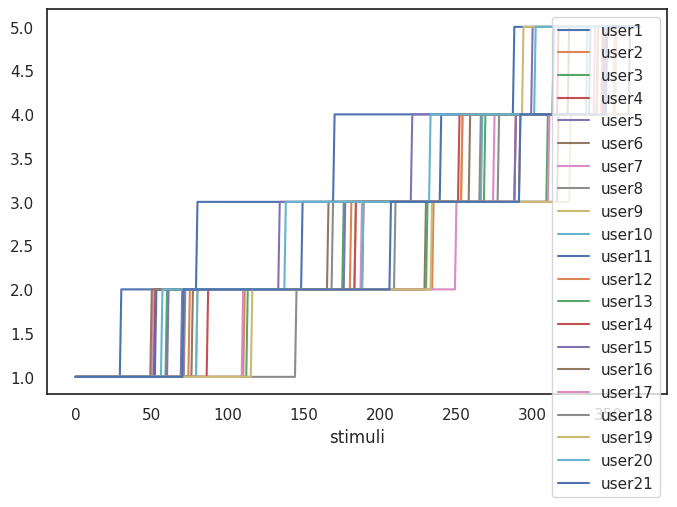

In [6]:

ax = None
for user in [x for x in du.columns if "user" in x]:
    ddd = du.sort_values(by=user).copy()
    ddd["c"] = range(len(ddd))
    ax = ddd.plot(x="c", y=user, ax=ax)
    ax.set_xlabel("stimuli")



In [7]:
da = pd.DataFrame()
for user in [x for x in du.columns if "user" in x]:
    #d(du[[user]])
    dd = du[[user]].copy()
    dd["rating"] = dd[user]
    dd["user"] = user
    dd = dd[["rating", "user"]]
    da = da.append(dd, ignore_index=True)
d(da.head())

/tmp/ipykernel_308336/1231059474.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  da = da.append(dd, ignore_index=True)
/tmp/ipykernel_308336/1231059474.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  da = da.append(dd, ignore_index=True)
/tmp/ipykernel_308336/1231059474.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  da = da.append(dd, ignore_index=True)
/tmp/ipykernel_308336/1231059474.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  da = da.append(dd, ignore_index=True)
/tmp/ipykernel_308336/1231059474.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

,rating,user
0,4,user1
1,4,user1
2,4,user1
3,3,user1
4,3,user1


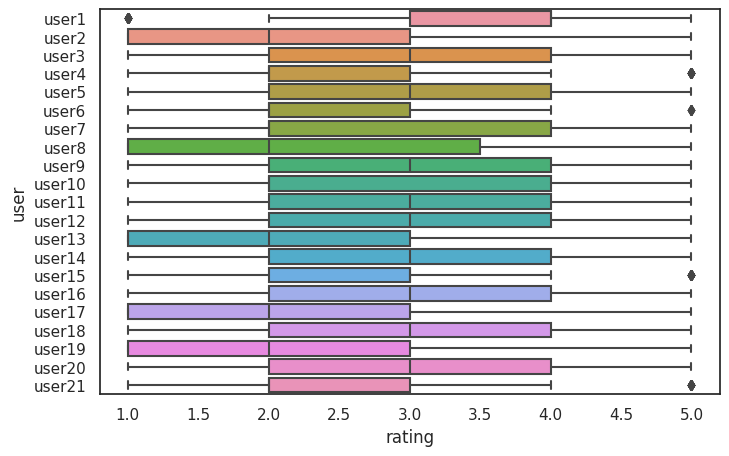

In [8]:
ax = sns.boxplot(y="user", x="rating", data=da)
plot(ax, "per_user")

create file for meta data

In [9]:
# meta data
du["crf"] = du["image_name"].apply(
    lambda x:
    int(x.split("_")[-3])
)
du["height"] = du["image_name"].apply(
    lambda x:
    int(x.split("_")[-1])
)
meta_cols = ["image_name", "crf", "height"]
d(du[meta_cols].head())
du[meta_cols].to_csv("meta.csv", index=False)

,image_name,crf,height
0,BennuProRes4444.mov_1frame_crf_03_height_0864,3,864
1,BennuProRes4444.mov_1frame_crf_06_height_0592,6,592
2,BennuProRes4444.mov_1frame_crf_08_height_0448,8,448
3,BennuProRes4444.mov_1frame_crf_13_height_0304,13,304
4,BennuProRes4444.mov_1frame_crf_21_height_0320,21,320


combine objective metrics with subjective ratings

In [10]:
do = pd.read_csv("objective_metrics.csv")
d(do.head())
dr = pd.read_csv("mos_ci.csv")
d(dr.head())

dm = pd.merge(dr, do, left_on="image_name", right_on="image")
d(dm.head())
dm.to_csv("objective_metrics_and_mos_ci.csv", index=False)

,image,vmaf,adm2,psnr,ssim,ms_ssim,vif_scale0,vif_scale1,vif_scale2,vif_scale3
0,Netflix_PierSeaside_4096x2160_60fps_10bit_420....,28.79331,0.60176,28.65663,0.96732,0.88339,0.20083,0.39495,0.54165,0.71453
1,Netflix_PierSeaside_4096x2160_60fps_10bit_420....,71.93411,0.84915,33.29191,0.99617,0.96498,0.35968,0.75384,0.90116,0.96320
2,Netflix_PierSeaside_4096x2160_60fps_10bit_420....,54.94602,0.75518,30.99616,0.99173,0.93779,0.27757,0.58879,0.77411,0.90799
3,Netflix_PierSeaside_4096x2160_60fps_10bit_420....,4.30320,0.35872,25.02071,0.79255,0.72787,0.13101,0.21333,0.26497,0.32416
4,Netflix_PierSeaside_4096x2160_60fps_10bit_420....,31.56868,0.61176,28.88457,0.97646,0.89433,0.21185,0.42824,0.59093,0.77793


,image_name,mos,ci,std
0,BennuProRes4444.mov_1frame_crf_03_height_0864,3.095238,0.699565,0.768424
1,BennuProRes4444.mov_1frame_crf_06_height_0592,2.904762,0.568885,0.624881
2,BennuProRes4444.mov_1frame_crf_08_height_0448,2.809524,0.547677,0.601585
3,BennuProRes4444.mov_1frame_crf_13_height_0304,2.476190,0.547677,0.601585
4,BennuProRes4444.mov_1frame_crf_21_height_0320,2.142857,0.435249,0.478091


,image_name,mos,ci,std,image,vmaf,adm2,psnr,ssim,ms_ssim,vif_scale0,vif_scale1,vif_scale2,vif_scale3
0,BennuProRes4444.mov_1frame_crf_03_height_0864,3.095238,0.699565,0.768424,BennuProRes4444.mov_1frame_crf_03_height_0864,96.55329,0.97798,55.46594,0.99986,0.99935,0.95478,0.99185,0.99633,0.99800
1,BennuProRes4444.mov_1frame_crf_06_height_0592,2.904762,0.568885,0.624881,BennuProRes4444.mov_1frame_crf_06_height_0592,91.59939,0.95523,51.85869,0.99946,0.99832,0.90892,0.96960,0.98441,0.99114
2,BennuProRes4444.mov_1frame_crf_08_height_0448,2.809524,0.547677,0.601585,BennuProRes4444.mov_1frame_crf_08_height_0448,86.01128,0.93306,49.23137,0.99851,0.99671,0.86305,0.93407,0.96006,0.97598
3,BennuProRes4444.mov_1frame_crf_13_height_0304,2.476190,0.547677,0.601585,BennuProRes4444.mov_1frame_crf_13_height_0304,66.93424,0.86470,44.07120,0.99220,0.98897,0.74103,0.81244,0.85182,0.88802
4,BennuProRes4444.mov_1frame_crf_21_height_0320,2.142857,0.435249,0.478091,BennuProRes4444.mov_1frame_crf_21_height_0320,52.66551,0.81816,40.36141,0.97856,0.97636,0.65859,0.71842,0.75014,0.77872


,image_name,mos,ci,std,image,vmaf,adm2,psnr,ssim,ms_ssim,vif_scale0,vif_scale1,vif_scale2,vif_scale3
0,BennuProRes4444.mov_1frame_crf_03_height_0864,3.095238,0.699565,0.768424,BennuProRes4444.mov_1frame_crf_03_height_0864,96.55329,0.97798,55.46594,0.99986,0.99935,0.95478,0.99185,0.99633,0.99800
1,BennuProRes4444.mov_1frame_crf_06_height_0592,2.904762,0.568885,0.624881,BennuProRes4444.mov_1frame_crf_06_height_0592,91.59939,0.95523,51.85869,0.99946,0.99832,0.90892,0.96960,0.98441,0.99114
2,BennuProRes4444.mov_1frame_crf_08_height_0448,2.809524,0.547677,0.601585,BennuProRes4444.mov_1frame_crf_08_height_0448,86.01128,0.93306,49.23137,0.99851,0.99671,0.86305,0.93407,0.96006,0.97598
3,BennuProRes4444.mov_1frame_crf_13_height_0304,2.476190,0.547677,0.601585,BennuProRes4444.mov_1frame_crf_13_height_0304,66.93424,0.86470,44.07120,0.99220,0.98897,0.74103,0.81244,0.85182,0.88802
4,BennuProRes4444.mov_1frame_crf_21_height_0320,2.142857,0.435249,0.478091,BennuProRes4444.mov_1frame_crf_21_height_0320,52.66551,0.81816,40.36141,0.97856,0.97636,0.65859,0.71842,0.75014,0.77872


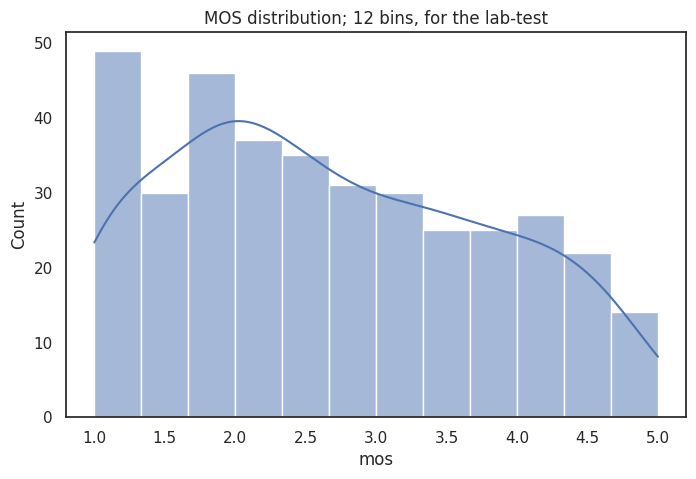

In [11]:
dratings = pd.read_csv("objective_metrics_and_mos_ci.csv")
d(dratings.head())

sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("white")
ax = sns.histplot(dratings["mos"], bins=12, kde=True)

ax.set_title("MOS distribution; 12 bins, for the lab-test")
plot(ax, "mos_dist")

checkout correlations of all objective metrics with subjective scores

['adm2', 'ms_ssim', 'psnr', 'ssim', 'vif_scale0', 'vif_scale1', 'vif_scale2', 'vif_scale3', 'vmaf']


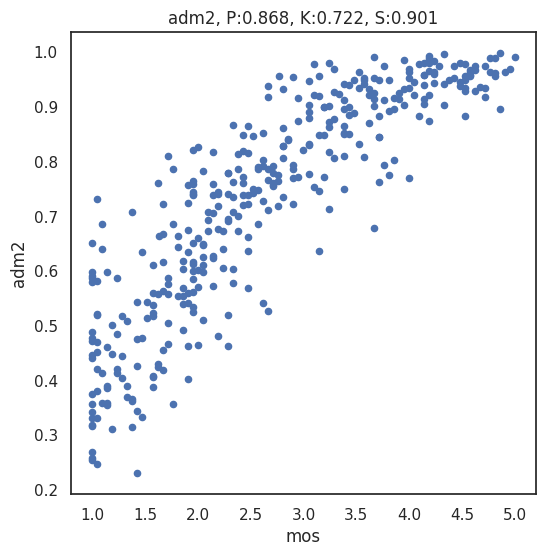

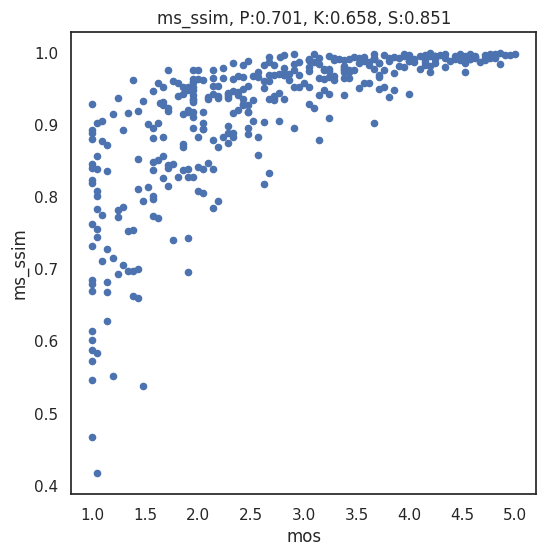

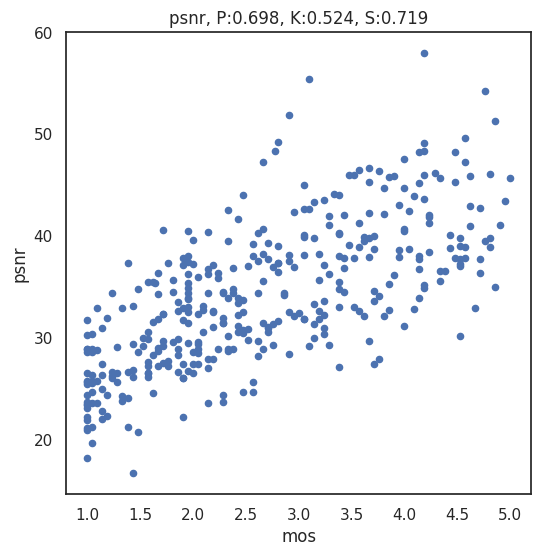

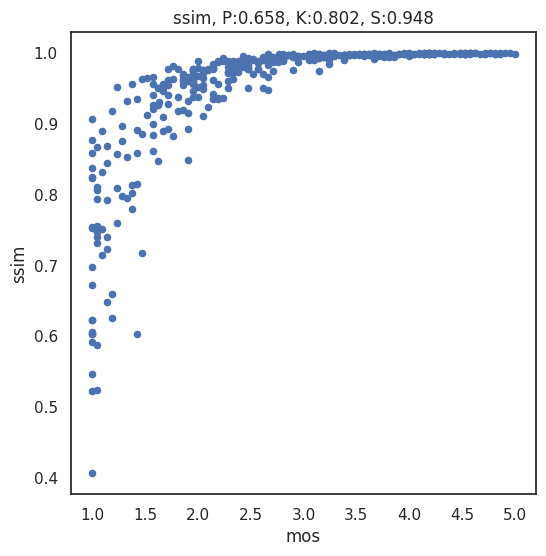

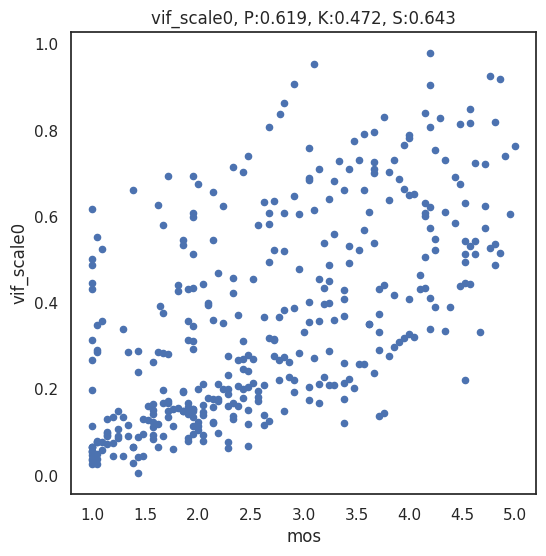

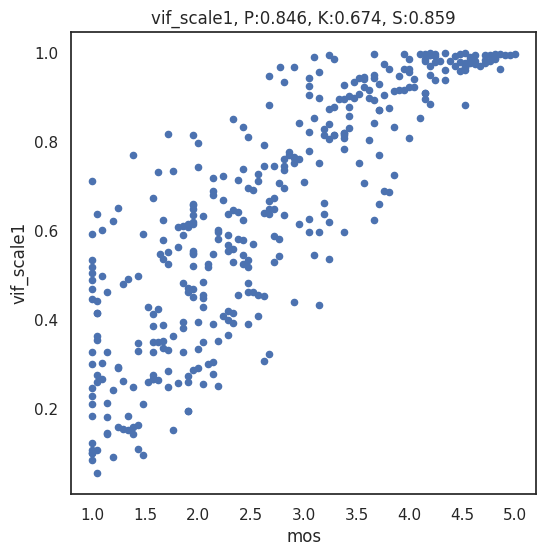

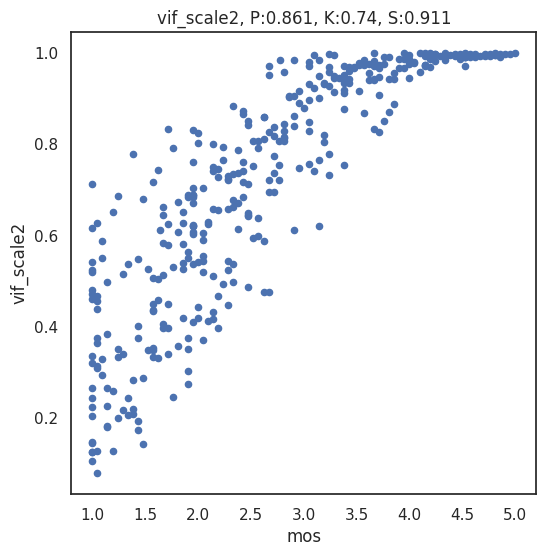

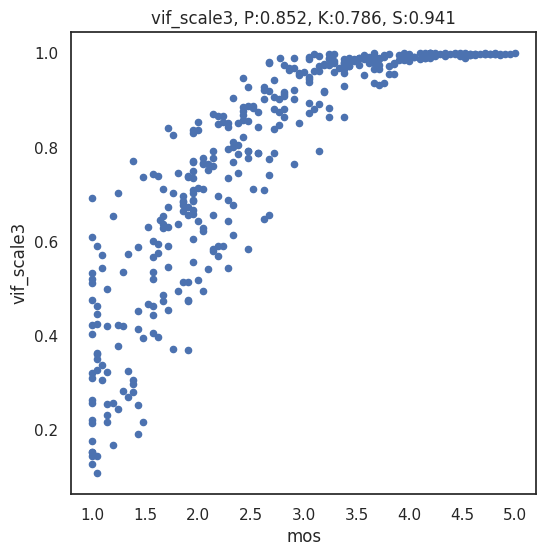

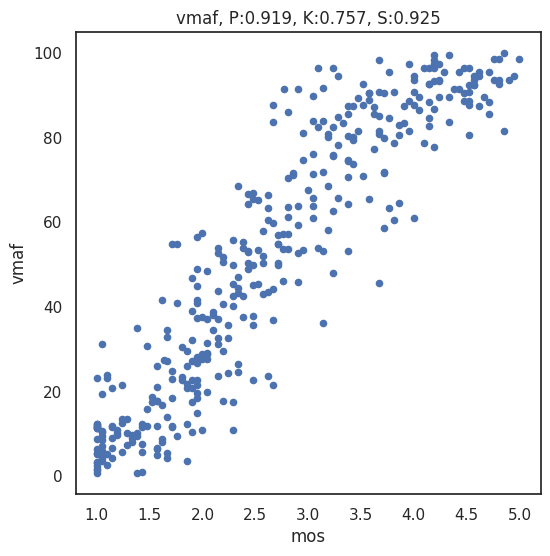

In [12]:
metrics = list(do.columns.difference(["image"]))
print(metrics)

corr_values = []
for m in metrics:
    p = dm[["mos", m]].corr(method="pearson")["mos"][1]
    k = dm[["mos", m]].corr(method="kendall")["mos"][1]
    s = dm[["mos", m]].corr(method="spearman")["mos"][1]
    title =f"{m}, P:{p.round(3)}, K:{k.round(3)}, S:{s.round(3)}"
    ax = dm[["mos", m]].plot(x="mos", y=m, kind="scatter", figsize=(6,6), title=title)
    plot(ax, f"corr_{m}")
    corr_values.append({
        "metric": m,
        "pearson": p,
        "kendall": k,
        "spearman": s
    }
    )
    
dcorr = pd.DataFrame(corr_values)
dcorr.to_csv("correlations.csv", index=False)

In [13]:
table = dcorr.sort_values(by="pearson", ascending=False).round(3)
d(table)

table.to_latex("objective_metrics_images.tex", index=False)

,metric,pearson,kendall,spearman
8,vmaf,0.919,0.757,0.925
0,adm2,0.868,0.722,0.901
6,vif_scale2,0.861,0.740,0.911
7,vif_scale3,0.852,0.786,0.941
5,vif_scale1,0.846,0.674,0.859
1,ms_ssim,0.701,0.658,0.851
2,psnr,0.698,0.524,0.719
3,ssim,0.658,0.802,0.948
4,vif_scale0,0.619,0.472,0.643


/tmp/ipykernel_308336/418336106.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table.to_latex("objective_metrics_images.tex", index=False)


vmaf correlation is the best, followed by adm2 (that is mainly used for vmaf in case of static videos)

here no linear or cubic or logistic mapping is performed, because it is hard to be done with one test